In [147]:
import pandas as pd
import numpy as np
import pickle as pkl
from matplotlib import pyplot as plt
import h5py as h5

import os 
import uproot, uproot_methods
import uproot_methods.classes.TLorentzVector as TLorentzVector
import uproot_methods.classes.TVector3 as TVector3

import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/higgsReconstruction/')
from JetCons import JetCons

In [2]:
#bkgFile = pd.read_hdf('/home/btannenw/Desktop/ML/anomalyDetection/lhcOlympics2020/events_LHCO2020_backgroundMC_Pythia.h5', stop=400)
#blackBox1 = pd.read_hdf('/home/btannenw/Desktop/ML/lhcOlympics2020/events_LHCO2020_BlackBox1.h5', stop=400)

topDir_hh  = '/home/btannenw/Desktop/ML/dihiggsMLProject/data/pp2hh4b_25k/'
topDir_qcd = '/home/btannenw/Desktop/ML/dihiggsMLProject/data/ppTo4b_50k/'

allEvents_hh = []
allEvents_qcd = []

for filename in os.listdir(topDir_hh):
    if filename.endswith(".pkl") and '7' in filename:
        temp = pkl.load( open( topDir_hh+filename, 'rb' )) 
        allEvents_hh += temp
    else:
        continue
        
for filename in os.listdir(topDir_qcd):
    if filename.endswith(".pkl") and '7' in filename:
        temp = pkl.load( open( topDir_qcd+filename, 'rb' )) 
        allEvents_qcd += temp
    else:
        continue

print( len(allEvents_hh), len(allEvents_qcd) )

2500 4999


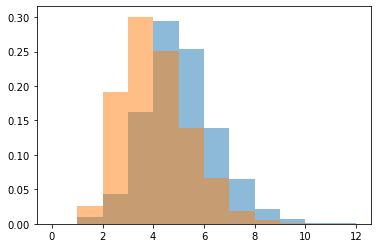

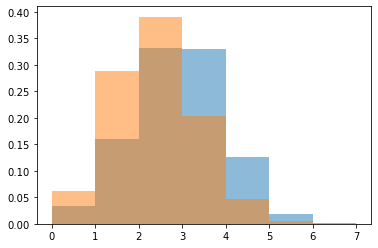

In [3]:
njets_hh = [ x['nJets'] for x in allEvents_hh]
ntags_hh = [ x['nBTags'] for x in allEvents_hh]
njets_qcd = [ x['nJets'] for x in allEvents_qcd]
ntags_qcd = [ x['nBTags'] for x in allEvents_qcd]

plt.hist( njets_hh, bins=12, range=[0,12], alpha=0.5, density=1)
plt.hist( njets_qcd, bins=12, range=[0,12], alpha=0.5, density=1)
plt.show()
plt.hist( ntags_hh, bins=7, range=[0,7], alpha=0.5, density=1)
plt.hist( ntags_qcd, bins=7, range=[0,7], alpha=0.5, density=1)
plt.show()

In [4]:
def returnSinglePhiRapidityPtList( eventList, consLabel ):
    """ return single list of phi, rapidity, pt"""
    
    _consCode = -1
    if consLabel == 'Tracks':
        _consCode = 0
    elif consLabel == 'Neutral Hadrons':
        _consCode = 1
    if consLabel == 'Photons':
        _consCode = 2
    
    _rap = [ constituent[5] for event in eventList for constituent in event['Constituents'] if constituent[6]==_consCode ]
    _phi = [ constituent[3] for event in eventList for constituent in event['Constituents'] if constituent[6]==_consCode ]
    _pt  = [ constituent[1] for event in eventList for constituent in event['Constituents'] if constituent[6]==_consCode ]
    _all = [_phi, _rap, _pt]
    
    return _all


def returnPhiRapidityPtLists( eventList ):
    """ return three lists of phi, rapidity, pt for later plotting """

    _track      = returnSinglePhiRapidityPtList( eventList, 'Tracks')
    _neutralHad = returnSinglePhiRapidityPtList( eventList, 'Neutral Hadrons')
    _photon     = returnSinglePhiRapidityPtList( eventList, 'Photons')    
    
    return _track, _neutralHad, _photon


tracks_hh, neutralHadrons_hh, photons_hh = returnPhiRapidityPtLists( allEvents_hh )
tracks_qcd, neutralHadrons_qcd, photons_qcd = returnPhiRapidityPtLists( allEvents_qcd )

In [5]:
def returnPlotOpts( _consLabel ):
    """ common function for returning plotting opts"""
    
    track_plotOpts  = dict(bins=(101, 101), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.Reds)
    #photon_plotOpts = dict(bins=(33, 33), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.YlGnBu)
    photon_plotOpts = dict(bins=(51, 51), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.Blues)
    nHad_plotOpts   = dict(bins=(51, 51), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.Greens)

    _plotOpts = {}
    if _consLabel == 'Tracks':
        _plotOpts = track_plotOpts
    if _consLabel == 'Photons':
        _plotOpts = photon_plotOpts
    if _consLabel == 'Neutral Hadrons':
        _plotOpts = nHad_plotOpts

    
    return _plotOpts
    

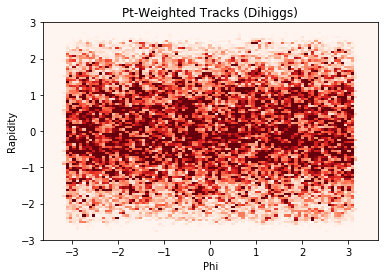

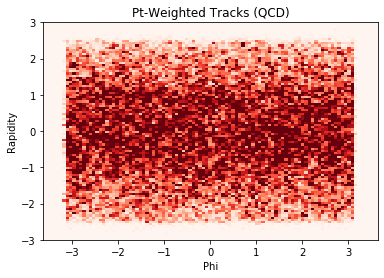

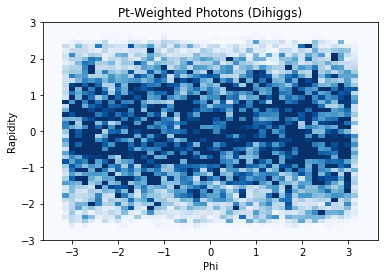

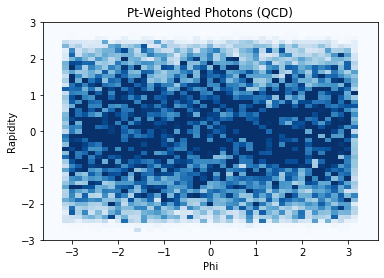

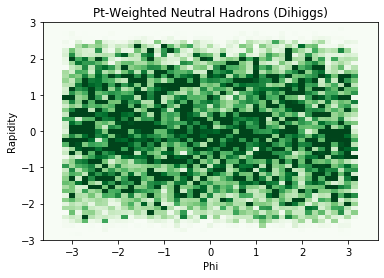

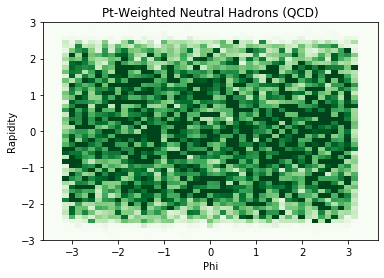

In [6]:
def makeSimplePlots( constituentList, sampleLabel='', consLabel='', nEventsToAverage=-1):
    """ make plots"""
    
    _plotOpts = returnPlotOpts( consLabel )
    _phi = constituentList[0]
    _rap = constituentList[1]
    _pt  = constituentList[2]
    if nEventsToAverage>0:
        _pt = [ constituent/nEventsToAverage for constituent in _pt ]

    #plt.hist2d( _phi, _rap, **_plotOpts )
    #plt.title('Raw {} ({})'.format(consLabel, sampleLabel) )
    #plt.xlabel('Phi')
    #plt.ylabel('Rapidity')
    #plt.show()
    
    bins, x_edges, y_edges, img = plt.hist2d( _phi, _rap, weights=_pt, **_plotOpts )
    bin_vals = [v for row in bins for v in row]
    #plt.hist(bin_vals)
    #plt.show()
    b_mean = np.mean(bin_vals)
    b_std = np.std(bin_vals)
    plt.clim( 0, b_mean + b_std)
    
    plt.title('Pt-Weighted {} ({})'.format(consLabel, sampleLabel))
    plt.xlabel('Phi')
    plt.ylabel('Rapidity')
    plt.show()

    return


makeSimplePlots( tracks_hh, 'Dihiggs', 'Tracks')
makeSimplePlots( tracks_qcd, 'QCD', 'Tracks')

makeSimplePlots( photons_hh, 'Dihiggs', 'Photons')
makeSimplePlots( photons_qcd, 'QCD', 'Photons')

makeSimplePlots( neutralHadrons_hh, 'Dihiggs', 'Neutral Hadrons')
makeSimplePlots( neutralHadrons_qcd, 'QCD', 'Neutral Hadrons')

In [93]:
def returnSingleEventPhiRapidityPtList( _event, _consLabel ):
    """ return single list of phi, rapidity, pt"""
    
    # *** 1. Set some collection-dependent variables
    _consCode = -1
    if _consLabel == 'Tracks':
        _consCode = 0
    elif _consLabel == 'Neutral Hadrons':
        _consCode = 1
    if _consLabel == 'Photons':
        _consCode = 2
    
    # *** 1. Get the phi/pt/rapidity from the stored constituents
    _rap = [ constituent[5] for constituent in _event['Constituents'] if constituent[6]==_consCode ]
    _phi = [ constituent[3] for constituent in _event['Constituents'] if constituent[6]==_consCode ]
    _pt  = [ constituent[1] for constituent in _event['Constituents'] if constituent[6]==_consCode ]
    
    # *** 2. Get TLorentzVectors
    _tlv = [JetCons(jc[0], jc[1], jc[2], jc[3], jc[4]).cons_LVec for jc in _event['Constituents']  if jc[6]==_consCode ]
    #v_all = TLorentzVector.PtEtaPhiMassLorentzVector(0,0,0,0)
    #for tlv in allTLVs:
    #    v_all += tlv
    #print("pt: {}, eta: {}, phi: {}, E: {}".format(v_all.pt, v_all.eta, v_all.phi, v_all.E))

    _all = [_phi, _rap, _pt, _tlv]
    
    return _all

def rotateByPhi(_phi, _rotAngle):
    return (((_phi - _rotAngle)+np.pi) % (2*np.pi))-np.pi 


def function_hist2d(_phi, _rap, _pt, _nbins_phi, _range_phi, _nbins_rap, _range_rap):

    # 12 bins
    _bins_phi = np.linspace( _range_phi[0], _range_phi[1], _nbins_phi+1)
    _bins_rap = np.linspace( _range_rap[0], _range_rap[1], _nbins_rap+1)
    #weights_phi = np.ones_like(a)/float(len(a))
    
    H, xedges, yedges = np.histogram2d( _rap, _phi, bins=(_bins_rap, _bins_phi), weights=_pt)

    return H

In [81]:
def returnRotatedData( _allEvents, _sampleLabel = '', _test=False):
    """ Make some event-by-event image plots and also do translation to unified frame """

    final_tracks   = [ [], [], [], [] ]
    final_nHadrons = [ [], [], [], [] ]
    final_photons  = [ [], [], [], [] ]
    
    for iEvent in range(0, len(_allEvents)):
        if iEvent > 3 and _test==True:
            break
            
        if 100*(iEvent/len(_allEvents))%10 == 0:
            print('{}% Processed'.format(100*(iEvent/len(_allEvents))))
    
        event = _allEvents[ iEvent ]
    
        # protection against events with 0 jets
        if event['nJets'] == 0:
        #if event['nJets'] < 2:
            continue
        
            
        _tracks   = returnSingleEventPhiRapidityPtList( event, 'Tracks')
        _nHadrons = returnSingleEventPhiRapidityPtList( event, 'Neutral Hadrons')
        _photons  = returnSingleEventPhiRapidityPtList( event, 'Photons')
        
        
        # *** Handle pT/ET weights
        _tracks_weights   = [ 1/sum(_tracks[2])   * x for x in _tracks[2] ]
        _nHadrons_weights = [ 1/sum(_nHadrons[2]) * x for x in _nHadrons[2] ]
        _photons_weights  = [ 1/sum(_photons[2])  * x for x in _photons[2] ]
        
        _tracks_sumWeights   = sum( _tracks_weights )
        _nHadrons_sumWeights = sum( _nHadrons_weights )
        _photons_sumWeights  = sum( _photons_weights )
       
        _totalWeights = _tracks_sumWeights + _photons_sumWeights + _nHadrons_sumWeights

         # *** Make total 4-vector for CM (center-of-mass)
        v_all         = TLorentzVector.PtEtaPhiMassLorentzVector(0,0,0,0)
        for tlv in _tracks[3]:
            v_all += tlv
        for tlv in _nHadrons[3]:
            v_all += tlv
        for tlv in _photons[3]:
            v_all += tlv
        #print("pt: {}, eta: {}, phi: {}, E: {}".format(v_all.pt, v_all.eta, v_all.phi, v_all.E))

    
        # *** Initial CMS calculations
        _tracks_scaled_phi   = [ x*y for x,y in zip(_tracks[0], _tracks_weights)]
        _nHadrons_scaled_phi = [ x*y for x,y in zip(_nHadrons[0], _nHadrons_weights)]
        _photons_scaled_phi  = [ x*y for x,y in zip(_photons[0], _photons_weights)]
        _tracks_scaled_rap   = [ x*y for x,y in zip(_tracks[1], _tracks_weights)]
        _nHadrons_scaled_rap = [ x*y for x,y in zip(_nHadrons[1], _nHadrons_weights)]
        _photons_scaled_rap  = [ x*y for x,y in zip(_photons[1], _photons_weights)]
        _phi_centroid = sum( _tracks_scaled_phi + _nHadrons_scaled_phi + _photons_scaled_phi ) / _totalWeights
        _rap_centroid = sum( _tracks_scaled_rap + _nHadrons_scaled_rap + _photons_scaled_rap ) / _totalWeights
        #_phi_centroid = v_all.phi
        #print("nJets: {}, phi centroid: {}, rap centroid: {}".format(event['nJets'], _phi_centroid, _rap_centroid))
        
        
        # *** Phi Rotation
        _tracks_phi_rot   = [rotateByPhi(x, _phi_centroid) for x in _tracks[0] ]
        _nHadrons_phi_rot = [rotateByPhi(x, _phi_centroid) for x in _nHadrons[0] ]
        _photons_phi_rot  = [rotateByPhi(x, _phi_centroid) for x in _photons[0] ]

        _tracks_scaledRotated_phi   = [ x*y for x,y in zip(_tracks_phi_rot, _tracks_weights)]
        _nHadrons_scaledRotated_phi = [ x*y for x,y in zip(_nHadrons_phi_rot, _nHadrons_weights)]
        _photons_scaledRotated_phi  = [ x*y for x,y in zip(_photons_phi_rot, _photons_weights)]
        _phi_centroid_CM = sum( _tracks_scaledRotated_phi + _nHadrons_scaledRotated_phi + _photons_scaledRotated_phi ) / _totalWeights

        
        # *** Rapidity Boost
        tlvz  = TLorentzVector.TLorentzVector(0, 0, -1*v_all.p3.z, v_all.t)
        boost_z   = (tlvz.p3/tlvz.p3.mag)*tlvz.beta

        _tracks_rap_boost2   = [ tlv.boost( boost_z).rapidity for tlv in _tracks[3]]
        _nHadrons_rap_boost2 = [ tlv.boost( boost_z).rapidity for tlv in _nHadrons[3]]
        _photons_rap_boost2  = [ tlv.boost( boost_z).rapidity for tlv in _photons[3]]
        
        # y_particle,lab = y_particle,CM + y_CM,lab
        _rap_cm = v_all.rapidity
        _tracks_rap_boost   = [ jc_rap - _rap_cm for jc_rap in _tracks[1]]
        _nHadrons_rap_boost = [ jc_rap - _rap_cm for jc_rap in _nHadrons[1]]
        _photons_rap_boost  = [ jc_rap - _rap_cm for jc_rap in _photons[1]]
    
        _tracks_pt_boost   = [ tlv.boost( boost_z).pt for tlv in _tracks[3]]
        _nHadrons_pt_boost = [ tlv.boost( boost_z).pt for tlv in _nHadrons[3]]
        _photons_pt_boost  = [ tlv.boost( boost_z).pt for tlv in _photons[3]]
        
        for i in range(0, len(_tracks_pt_boost)):
            if (_tracks_pt_boost[i] - _tracks[2][i]) > 0.001:
                print("shit, {} {}".format(_tracks_pt_boost[i] , _tracks[2][i]))

        for i in range(0, len(_tracks_rap_boost)):
            if (_tracks_rap_boost[i] - _tracks_rap_boost2[i]) > 0.001:
                print("shit2, {} {}".format(_tracks_rap_boost[i] , _tracks_rap_boost2[i]))

        _tracks_scaledRotated_rap   = [ x*y for x,y in zip(_tracks_rap_boost, _tracks_weights)]
        _nHadrons_scaledRotated_rap = [ x*y for x,y in zip(_nHadrons_rap_boost, _nHadrons_weights)]
        _photons_scaledRotated_rap  = [ x*y for x,y in zip(_photons_rap_boost, _photons_weights)]
        
        _rap_centroid_CM = sum( _tracks_scaledRotated_rap + _nHadrons_scaledRotated_rap + _photons_scaledRotated_rap ) / _totalWeights
        
        #print("nJets: {}, phi centroid (CM): {}, rap centroid (CM): {}".format(event['nJets'], _phi_centroid_CM, _rap_centroid_CM))
          
        # *** Make event images
        #_nbins_phi, _range_phi, _nbins_rap, _range_rap
        _imgOpts = dict( _nbins_phi=51, _range_phi=[-1*np.pi-0.5, np.pi+0.5], _nbins_rap=51, _range_rap=[-3.0, 3.0] )
        _tracks_img = function_hist2d(_tracks_phi_rot, _tracks_rap_boost, _tracks_weights, **_imgOpts)
        _nHadrons_img = function_hist2d(_nHadrons_phi_rot, _nHadrons_rap_boost, _nHadrons_weights, **_imgOpts)
        _photons_img = function_hist2d(_photons_phi_rot, _photons_rap_boost, _photons_weights, **_imgOpts)
        final_tracks[3].append( _tracks_img )
        final_nHadrons[3].append( _nHadrons_img )
        final_photons[3].append( _photons_img )
        
        
        # *** Make aggregates of all events
        final_tracks[0]   += _tracks_phi_rot
        final_tracks[1]   += _tracks_rap_boost
        final_tracks[2]   += _tracks_weights
        final_nHadrons[0] += _nHadrons_phi_rot
        final_nHadrons[1] += _nHadrons_rap_boost
        final_nHadrons[2] += _nHadrons_weights
        final_photons[0]  += _photons_phi_rot
        final_photons[1]  += _photons_rap_boost
        final_photons[2]  += _photons_weights

        
        _plotOpts = returnPlotOpts( 'Tracks' )
    
        if (iEvent <3): 
            plt.hist2d( _tracks[0], _tracks[1], **_plotOpts )
            plt.title('Raw {} Event'.format(_sampleLabel))
            plt.xlabel('Rapidity')
            plt.ylabel('Eta')
            plt.show()
    
            plt.hist2d( _tracks[0], _tracks[1], weights=_tracks[2], **_plotOpts)
            plt.xlabel('Rapidity')
            plt.ylabel('Eta')
            plt.title('Pt-Weighted {} Event'.format(_sampleLabel))
            plt.show()

            plt.hist2d( _tracks[0], _tracks[1], weights=_tracks_weights, **_plotOpts)
            plt.xlabel('Rapidity')
            plt.ylabel('Eta')
            plt.title('Pt-Weighted 2 {} Event'.format(_sampleLabel))
            plt.show()
        
            plt.hist2d( _tracks_phi_rot, _tracks_rap_boost, **_plotOpts)
            plt.title('pt weighted, rot in phi')
            plt.xlabel('Phi')
            plt.ylabel('Eta')
            plt.show()
        
    return final_tracks, final_nHadrons, final_photons

0.0% Processed


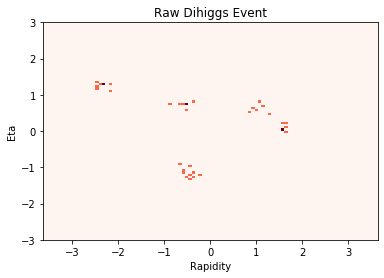

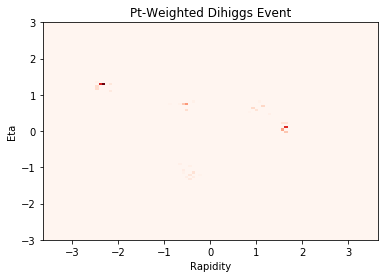

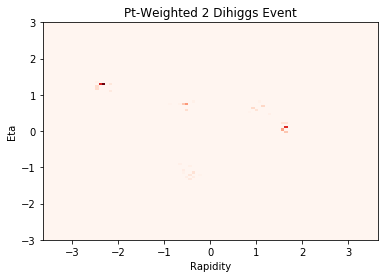

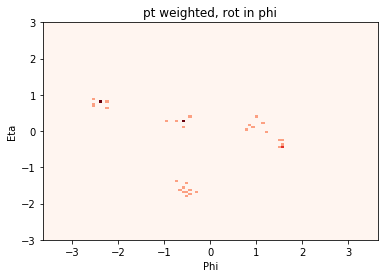

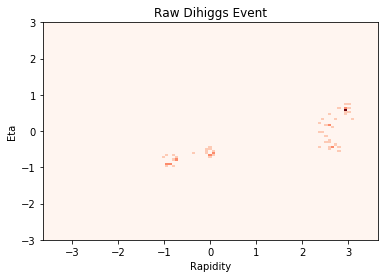

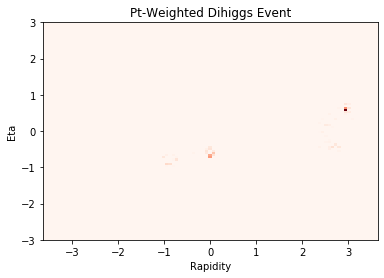

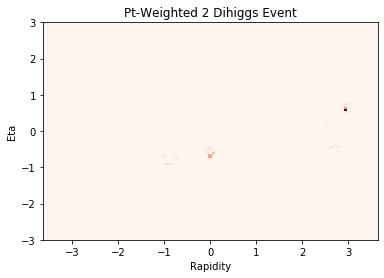

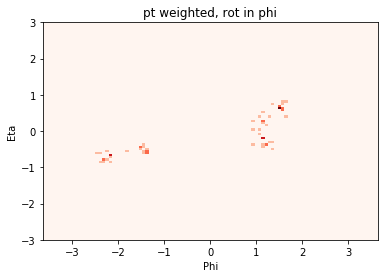

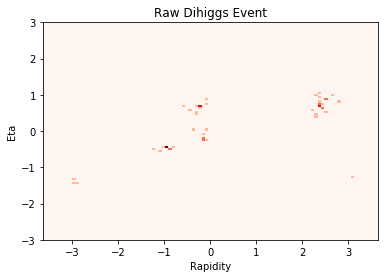

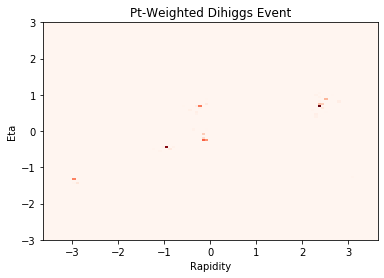

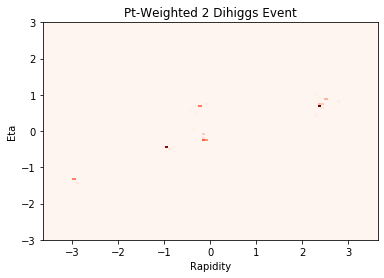

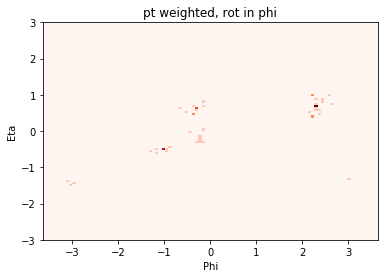

10.0% Processed
20.0% Processed
30.0% Processed
40.0% Processed
50.0% Processed
60.0% Processed
70.0% Processed
80.0% Processed
90.0% Processed
0.0% Processed


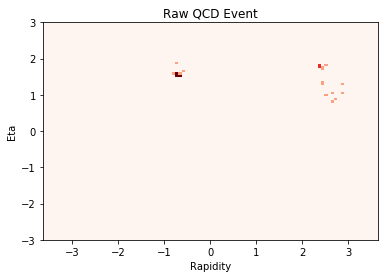

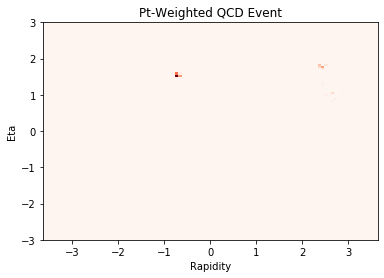

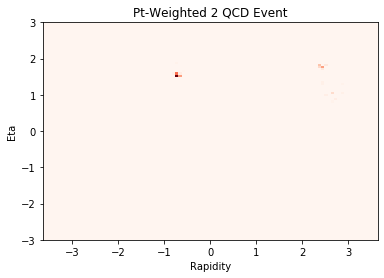

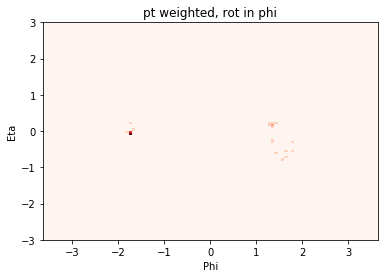

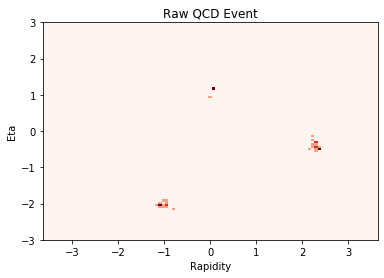

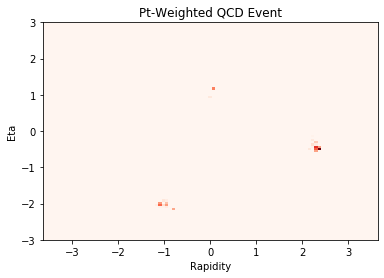

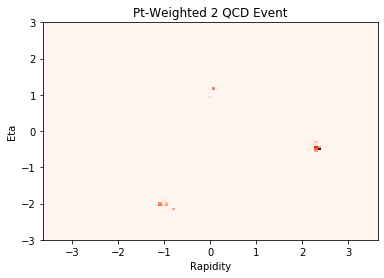

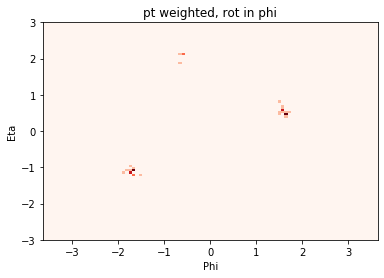

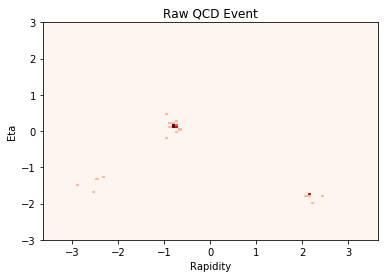

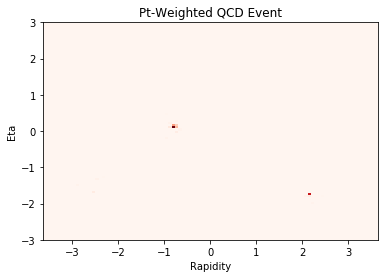

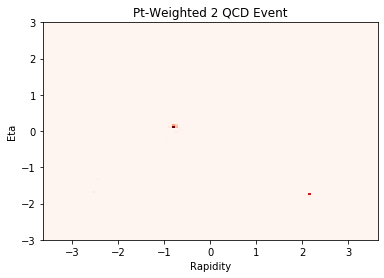

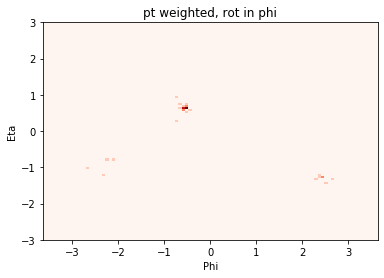

In [94]:
f_tracks_hh, f_nHadrons_hh, f_photons_hh    = returnRotatedData( allEvents_hh, 'Dihiggs')
f_tracks_qcd, f_nHadrons_qcd, f_photons_qcd = returnRotatedData( allEvents_qcd, 'QCD')

In [ ]:
test_tracks_hh, test_nHadrons_hh, test_photons_hh    = returnRotatedData( allEvents_hh, 'Dihiggs', _test=True)
test_tracks_qcd, test_nHadrons_qcd, test_photons_qcd = returnRotatedData( allEvents_qcd, 'QCD', _test=True)

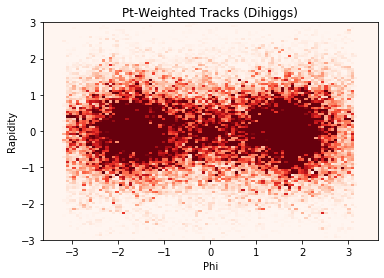

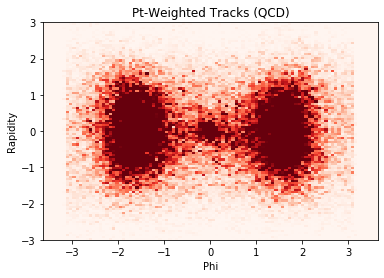

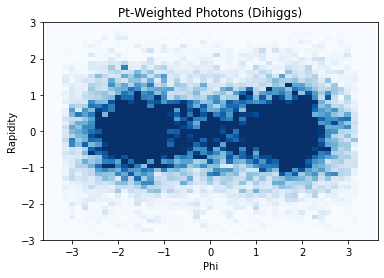

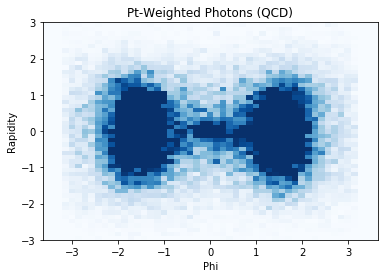

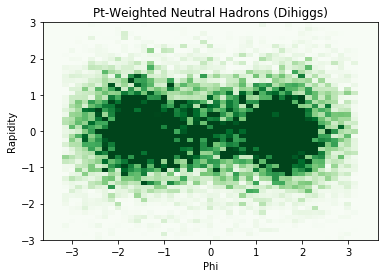

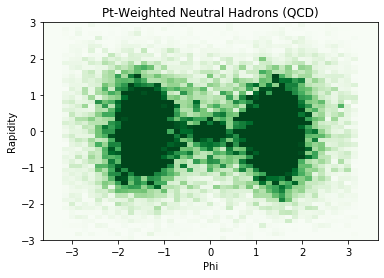

In [83]:
#f_tracks_hh[2][1]
makeSimplePlots( f_tracks_hh, 'Dihiggs', 'Tracks', len(allEvents_hh))
makeSimplePlots( f_tracks_qcd, 'QCD', 'Tracks', len(allEvents_qcd))

makeSimplePlots( f_photons_hh, 'Dihiggs', 'Photons', len(allEvents_hh))
makeSimplePlots( f_photons_qcd, 'QCD', 'Photons', len(allEvents_qcd))

makeSimplePlots( f_nHadrons_hh, 'Dihiggs', 'Neutral Hadrons', len(allEvents_hh))
makeSimplePlots( f_nHadrons_qcd, 'QCD', 'Neutral Hadrons', len(allEvents_qcd))

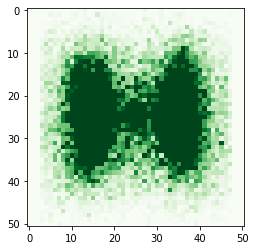

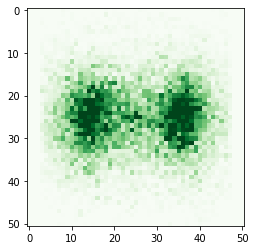

In [146]:
plt.imshow(f_tracks_hh[3][0], cmap=plt.cm.Reds)
plt.clim(0,.1)

sum2 = np.zeros_like(f_tracks_hh[3][0])
sum3 = np.zeros_like(f_tracks_hh[3][0])

for iEvt in range(0, len(f_nHadrons_qcd[3])):
    sum2 += f_nHadrons_qcd[3][iEvt]
    
for iEvt in range(0, len(f_nHadrons_hh[3])):
    sum3 += f_nHadrons_hh[3][iEvt]

plt.imshow(sum2, cmap=plt.cm.Greens)
plt.clim(0,3)
plt.show()

plt.imshow(sum3, cmap=plt.cm.Greens)
plt.clim(0,5)
plt.show()


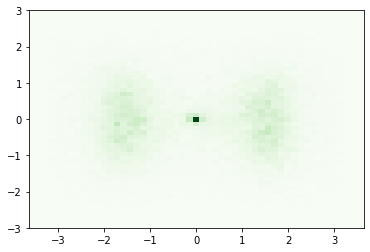

In [45]:
nh_plotOpts = returnPlotOpts( 'Neutral Hadrons' )
iEvt = 5
bins, x_edges, y_edges, img = plt.hist2d( f_tracks_hh[0], f_tracks_hh[1], weights=f_tracks_hh[2], **nh_plotOpts )
plt.clim(0,2)
bins2, x_edges2, y_edges2, img2 = plt.hist2d( f_nHadrons_hh[0], f_nHadrons_hh[1], weights=f_nHadrons_hh[2], **nh_plotOpts )
bins3, x_edges3, y_edges3, img3 = plt.hist2d( f_photons_hh[0], f_photons_hh[1], weights=f_photons_hh[2], **nh_plotOpts )

bins4, x_edges4, y_edges4, img4 = plt.hist2d( f_tracks_qcd[0], f_tracks_qcd[1], weights=f_tracks_qcd[2], **nh_plotOpts )
bins5, x_edges5, y_edges5, img5 = plt.hist2d( f_nHadrons_qcd[0], f_nHadrons_qcd[1], weights=f_nHadrons_qcd[2], **nh_plotOpts )
bins6, x_edges6, y_edges6, img6 = plt.hist2d( f_photons_qcd[0], f_photons_qcd[1], weights=f_photons_qcd[2], **nh_plotOpts )


In [46]:
im = np.stack((bins, bins2, bins3), axis=-1)
im2 = np.stack((bins4, bins5, bins6), axis=-1)

In [31]:
im.shape

(51, 51, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


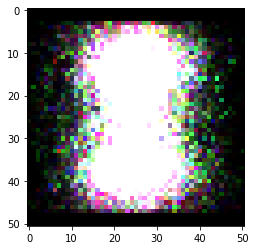

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


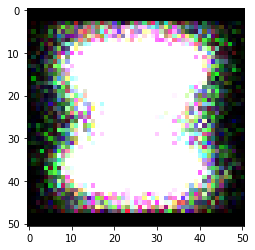

In [47]:
plt.imshow(im)
plt.show()
plt.imshow(im2)
plt.show()

In [180]:
hf = h5.File('test4_data.h5', 'w')
hf.create_dataset('trackImgs', data=f_tracks_hh[3], compression="gzip", compression_opts=3)
hf.create_dataset('nHadronImgs', data=f_nHadrons_hh[3], compression="gzip", compression_opts=3)
hf.create_dataset('photonImgs', data=f_photons_hh[3], compression="gzip", compression_opts=3)
hf.close()

In [182]:
hr4 = h5.File('test_data.h5', 'r')

In [186]:
iEvt = 73
for x in range(0,51):
    for y in range(0,51):
        if hr['nHadronImgs'][iEvt][x][y] - f_nHadrons_hh[3][iEvt][x][y] > 0.1:
            print ("shit {} {}".format(hr4['nHadronImgs'][iEvt][x][y] , f_tracks_hh[3][iEvt][x][y]))

In [193]:
vals = [y for x in hr4['nHadronImgs'][6] for y in x]

In [194]:
sum(vals)

1.0